<a href="https://www.kaggle.com/code/aleksandrmorozov123/cv-object-detection?scriptVersionId=232083079" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-camera-photos/labels_train.csv
/kaggle/input/car-camera-photos/images/images/1479498457448232030.jpg
/kaggle/input/car-camera-photos/images/images/1478020894712588023.jpg
/kaggle/input/car-camera-photos/images/images/1479502069714972898.jpg
/kaggle/input/car-camera-photos/images/images/1478899347777707565.jpg
/kaggle/input/car-camera-photos/images/images/1479500482587459937.jpg
/kaggle/input/car-camera-photos/images/images/1478732638089007825.jpg
/kaggle/input/car-camera-photos/images/images/1479498594981336285.jpg
/kaggle/input/car-camera-photos/images/images/1478897449382202627.jpg
/kaggle/input/car-camera-photos/images/images/1478020841719652984.jpg
/kaggle/input/car-camera-photos/images/images/1479501472176216081.jpg
/kaggle/input/car-camera-photos/images/images/1479501825699578212.jpg
/kaggle/input/car-camera-photos/images/images/1479504363872203561.jpg
/kaggle/input/car-camera-photos/images/images/1479505311435596750.jpg
/kaggle/input/car-camera-photos/images/im

**In this notebook I'll try inference with pre-trained vision transformers**

**RT-DETR model inference**

In [50]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install -q accelerate
!pip install -q roboflow
!pip install -q torchmetrics
!pip install -q "albumentations>=1.4.5"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [51]:
import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [52]:
# load the model
CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
DEVICE = torch.device ("cuda" if torch.cuda.is_available () else "cpu")

model = AutoModelForObjectDetection.from_pretrained (CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained (CHECKPOINT)

In [53]:
#  run inference
image = Image.open ('/kaggle/input/indoor-object-detection/train/images/009ae3d6fd97c1fc.jpg')
inputs = processor (image, return_tensors = "pt").to(DEVICE)

with torch.no_grad ():
    outputs = model (**inputs)
    
w, h = image.size
results = processor.post_process_object_detection (outputs, target_sizes = [(h, w)], threshold = 0.3)

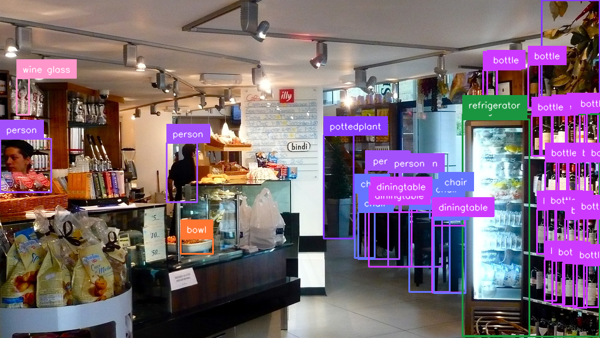

In [54]:
# display result without NMS
detections = sv.Detections.from_transformers (results [0])
labels = [
    model.config.id2label [class_id]
    for class_id
    in detections.class_id
]

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator ().annotate (annotated_image, detections)
annotated_image = sv.LabelAnnotator ().annotate (annotated_image, detections, labels = labels)
annotated_image.thumbnail ((600, 600))
annotated_image

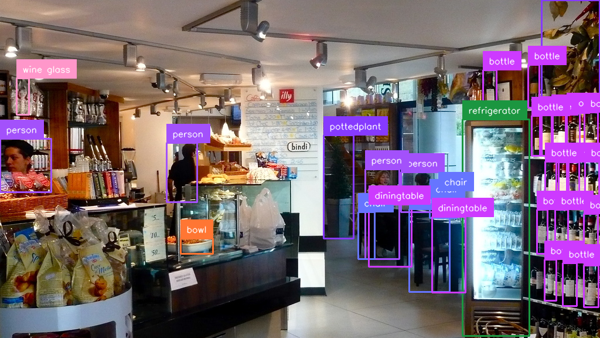

In [55]:
# display result without NMS
detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)
labels = [
    model.config.id2label[class_id]
    for class_id
    in detections.class_id
]
annotated_image = image.copy()
annotated_image = sv.BoxAnnotator ().annotate (annotated_image, detections)
annotated_image = sv.LabelAnnotator ().annotate (annotated_image, detections, labels = labels)
annotated_image.thumbnail ((600, 600))
annotated_image

**Run inference with pre-trained base Florence-2 model**

In [56]:
!pip install -q transformers flash_attn timm einops peft
!pip install -q roboflow git+https://github.com/roboflow/supervision.git
!pip install -q transformers flash_attn timm einops supervision==0.22.0rc1

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [57]:
import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

In [58]:
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION)

**Load a pre-trained large Florence-2 model**

In [59]:
CHECKPOINT = "microsoft/Florence-2-large-ft"

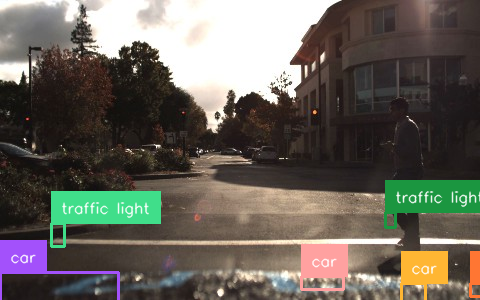

In [60]:
image_1 = Image.open ("/kaggle/input/car-camera-photos/images/images/1478020283697257862.jpg")

inputs = processor (text = text, images = image_1, return_tensors = "pt").to(DEVICE)
generated_ids = model.generate (input_ids = inputs ["input_ids"],
                               pixel_values = inputs ["pixel_values"],
                               max_new_tokens = 1024,
                               num_beams = 3)
generated_text = processor.batch_decode (generated_ids, skip_special_tokens = False)[0]
response = processor.post_process_generation (generated_text, task = task, image_size = image.size)
detections = sv.Detections.from_vlm (sv.VLM.FLORENCE_2, response, resolution_wh = image.size)

bounding_box_annotator = sv.BoxAnnotator (color_lookup = sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator (color_lookup = sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate (image_1, detections)
image = label_annotator.annotate (image_1, detections)
image.thumbnail ((600, 600))
image

In [61]:
# wrap inference code into utility function
def run_inference(image: Image, task: str, text: str = ""):
    prompt = task + text
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(generated_text, task=task, image_size=image.size)

In [62]:
# example <CAPTION> inference
image = Image.open("/kaggle/input/car-camera-photos/images/images/1478020328701570552.jpg")
task = "<CAPTION>"

response = run_inference(image=image, task=task)
response

{'<CAPTION>': 'A city street lined with trees and buildings.'}

In [63]:
# example `<DETAILED_CAPTION>` inference
image = Image.open("/kaggle/input/indoor-object-detection/train/images/0231d1c677d693a4.jpg")
task = "<DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
response

{'<DETAILED_CAPTION>': 'In this image we can see a person standing. In front of him there is a refrigerator. Inside the refrigerator there are bottles, tins and some other items. In the background of the image there is wall.'}

In [64]:
# example `<MORE_DETAILED_CAPTION>` inference
image = Image.open("/kaggle/input/indoor-object-detection/train/images/09dcaaf01c06516b.jpg")
task = "<MORE_DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
response

{'<MORE_DETAILED_CAPTION>': "This is a picture of a kitchen. There is a refrigerator in the kitchen. The refrigerator is white. There are bottles in the refrigerator. The bottles are dark blue and yellow. There's a box of chips on the counter. The box is black and white. The chips are gold and red. The bottle has a red label on it."}

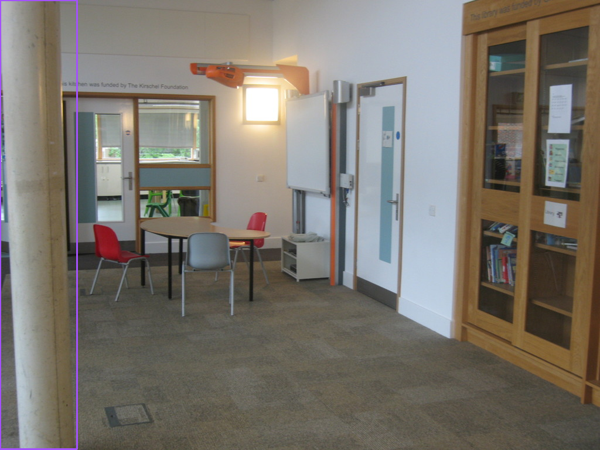

In [65]:
# Example `<CAPTION_TO_PHRASE_GROUNDING>` inference
image = Image.open("/kaggle/input/indoor-object-detection/train/images/0bf98072f26753f8.jpg")
task = "<CAPTION_TO_PHRASE_GROUNDING>"
text = "tail"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_vlm(sv.VLM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In this image we can see a building, there is a board with some text on it, there are some objects on the table, we can also see some chairs, a person sitting on the chair, a door with a door mat, a window, a wall with a window and an air conditioner, a light and the sky.


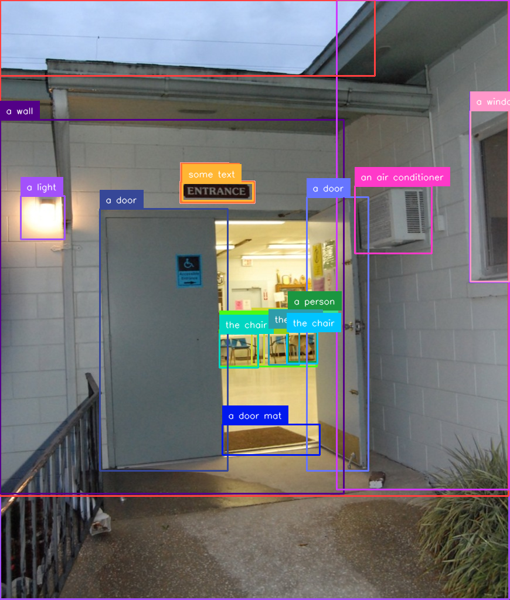

In [66]:
# example `<DETAILED_CAPTION>` + `<CAPTION_TO_PHRASE_GROUNDING>` combo inference
image = Image.open("/kaggle/input/indoor-object-detection/train/images/0c49829dd1e2d32f.jpg")
task = "<DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
text = response[task]

task = "<CAPTION_TO_PHRASE_GROUNDING>"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_vlm(sv.VLM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))

print(text)
image

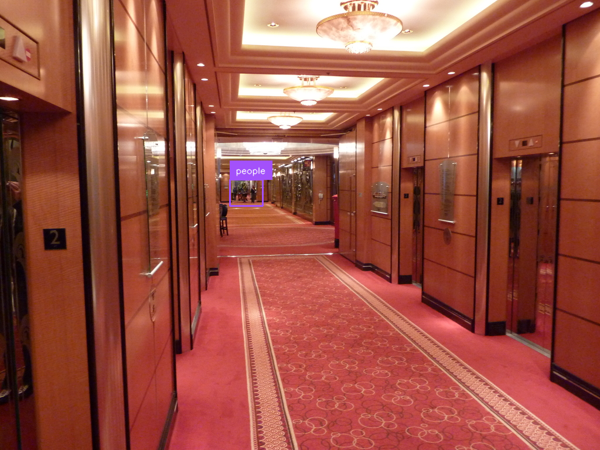

In [67]:
# example `<OPEN_VOCABULARY_DETECTION>` inference
image = Image.open("/kaggle/input/indoor-object-detection/train/images/0d01ee60fc82c415.jpg")
task = "<OPEN_VOCABULARY_DETECTION>"
text = "people"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_vlm(sv.VLM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

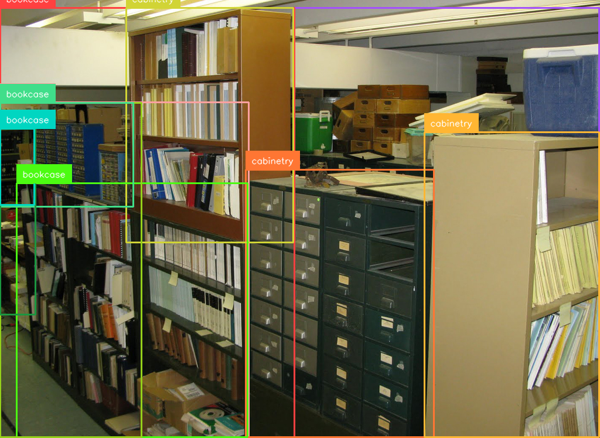

In [68]:
# example `<DENSE_REGION_CAPTION>` inference
image = Image.open("/kaggle/input/indoor-object-detection/train/images/0f238c501cc1f25b.jpg")
task = "<DENSE_REGION_CAPTION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_vlm(sv.VLM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

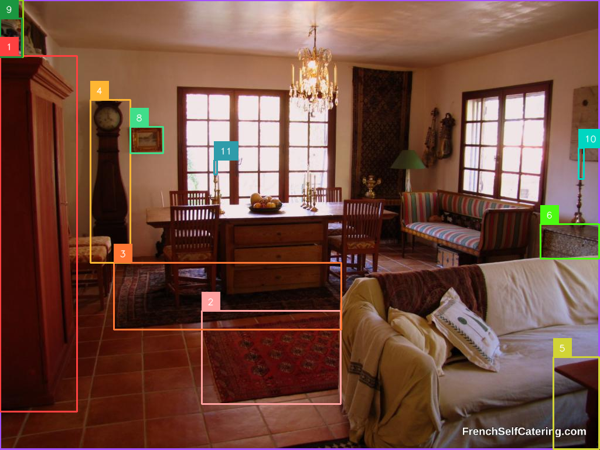

In [69]:
# example `<REGION_PROPOSAL>` inference
image = Image.open("/kaggle/input/indoor-object-detection/train/images/1b8116a074361a4c.jpg")
task = "<REGION_PROPOSAL>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_vlm(sv.VLM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

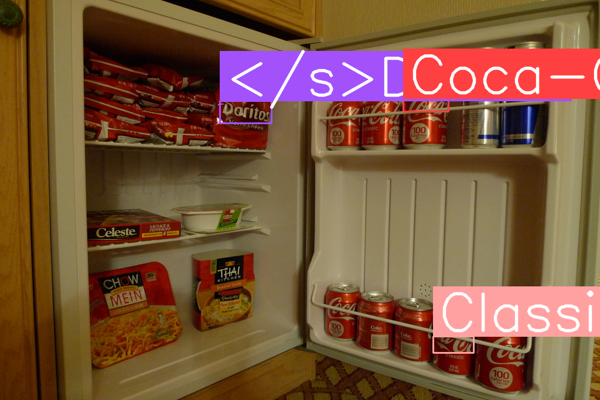

In [70]:
# example `<OCR_WITH_REGION>` inference
image = Image.open("/kaggle/input/indoor-object-detection/train/images/22aa40cd91b4c259.jpg")
task = "<OCR_WITH_REGION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_vlm(sv.VLM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    text_scale=3,
    text_thickness=4
)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

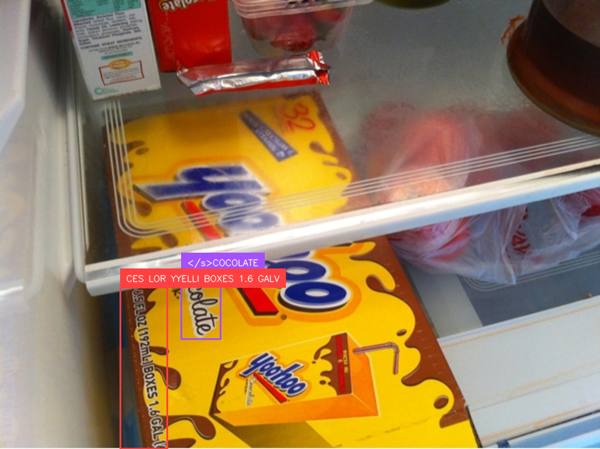

In [71]:
image = Image.open("/kaggle/input/indoor-object-detection/train/images/06fd633136a92428.jpg")
task = "<OCR_WITH_REGION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_vlm(sv.VLM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [72]:
# example <OCR> inference
image = Image.open("/kaggle/input/indoor-object-detection/train/images/861f42088328f1ca.jpg")
task = "<OCR>"

response = run_inference(image=image, task=task)
response[task]

"HENNEYSSPITAIREBISHL'OPSTINGERFrench'sVevoTALETHELLIGU.BELMANTER TORREITABEALER TORRREITANOT GRIGIOSINOCEInnocetDietCokeFRIDGE PACKFRIDE PACKFIT'S EAST IN FRIDGE PACKFRIDCE PACKFITS EASILY IN FRADIOFRIDEE PACK"

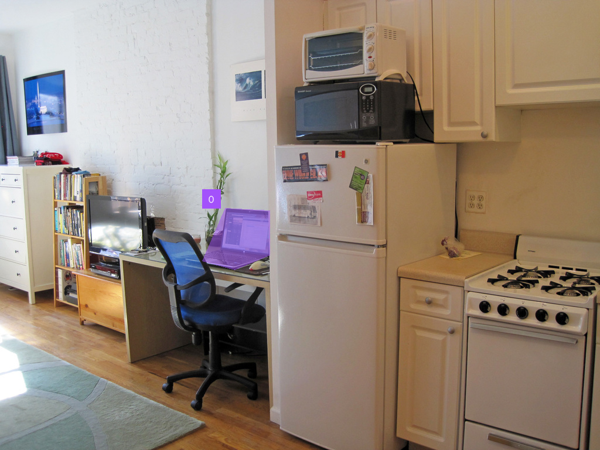

In [73]:
# example <REFERRING_EXPRESSION_SEGMENTATION> inference
image = Image.open("/kaggle/input/indoor-object-detection/train/images/9484b5e5c9738ff8.jpg")
task = "<REFERRING_EXPRESSION_SEGMENTATION>"
text = "laptop"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_vlm(sv.VLM.FLORENCE_2, response, resolution_wh=image.size)

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = mask_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image